In [1]:
import os, glob, re, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

FEATURE_DIR = "NSR_SCD_Features_CSV_1h_10min_segments"   # change if needed

In [2]:
def parse_filename(path):
    name = os.path.basename(path)
    is_scd = name.startswith("SCD")
    parts  = name.split('_')
    subj   = parts[1]
    ordinal = parts[2]                # First…Sixth
    order = ["First","Second","Third","Fourth","Fifth","Sixth"]
    idx = order.index(ordinal)
    # SCD order reversed: Sixth→0 … First→5
    idx = 5 - idx if is_scd else idx
    return int(is_scd), subj, idx

In [3]:
FEATURE_DIR = "NSR_SCD_Features_CSV_1h_10min_segments" 

def load_subject_dict(feature_dir):
    subj_map = {}
    for path in glob.glob(os.path.join(feature_dir, "*.csv")):
        label, subj, seg_idx = parse_filename(path)
        features = pd.read_csv(path).values.squeeze()   # eight‑element row

        print(label, features)
        if subj not in subj_map:
            subj_map[subj] = {"label": label, "segments": [None]*6}
        subj_map[subj]["segments"][seg_idx] = features
    # check completeness
    # for s, info in subj_map.items():
    #     if None in info["segments"]:
    #         raise ValueError(f"Subject {s} missing segment(s)")
    return subj_map

subject_dict = load_subject_dict(FEATURE_DIR)
print("Loaded", len(subject_dict), "subjects")

0 [0.77871704 0.32125417 0.0390625  0.09967578 0.06323338 0.04719687
 0.24683483 0.03169763 0.485      0.362      0.5625     3.        ]
0 [0.66473883 0.35151649 0.0546875  0.08508657 0.059      0.05011111
 0.26427112 0.03975563 0.531      0.451      0.3671875  2.5       ]
0 [0.78732525 0.3883831  0.015625   0.10077763 0.05770751 0.04769433
 0.26941392 0.03421889 0.438      0.362      0.5546875  3.6796875 ]
0 [0.77215395 0.33053766 0.0546875  0.09883571 0.06036269 0.04650259
 0.23815599 0.03084307 0.466      0.359      0.5        2.7578125 ]
0 [0.79592835 0.3286479  0.0625     0.10187883 0.062      0.04506667
 0.24651377 0.03097186 0.465      0.338      0.5078125  2.9296875 ]
0 [0.77286216 0.34044703 0.03125    0.09892636 0.05692109 0.04333765
 0.24220083 0.03133817 0.44       0.335      0.5859375  2.3671875 ]
0 [0.6974796  0.53079977 0.2578125  0.08927739 0.0966161  0.0957993
 0.35869838 0.0514278  0.828      0.821      0.140625   3.25      ]
0 [0.66210721 0.48248174 0.2265625  0.0847

In [4]:
X_tr, y_tr, X_te, y_te = [], [], [], []
for subj, info in subject_dict.items():
    lbl  = info["label"]
    segs = info["segments"]
    X_tr.append(segs[0])              # first 5‑min
    y_tr.append(lbl)
    X_te.extend(segs[1:])             # remaining 5
    y_te.extend([lbl]*5)

In [5]:
X_tr = np.vstack(X_tr)
#X_te = np.vstack(X_te)
y_tr = np.array(y_tr)
#y_te = np.array(y_te)

In [6]:
scaler = StandardScaler().fit(X_tr)

In [7]:
X_tr = scaler.transform(X_tr)
#X_te = scaler.transform(X_te)

In [8]:
N_FILT, K, DIL_BASE, DROP, DENSE = 64, 2, [1,2,4,8,16,32,64], 0.5, 512

def inception_branch(x, f, k):
    return layers.Conv1D(f, k, padding="same", activation="relu")(x)

def se_block(x, r=8):
    ch = x.shape[-1]
    s  = layers.GlobalAveragePooling1D()(x)
    s  = layers.Dense(ch//r, activation="relu")(s)
    s  = layers.Dense(ch,      activation="sigmoid")(s)
    s  = layers.Reshape((1, ch))(s)
    return layers.Multiply()([x, s])

def build_wavenet(depth, lr):
    """Hybrid Inception‑Dense‑SE 1‑D CNN (depth = # hybrid blocks)."""
    inp = Input(shape=(12,))
    x   = layers.Reshape((12,1))(inp)
    # point‑wise embedding
    x   = layers.Conv1D(128, 1, activation="relu")(x)
    x   = layers.BatchNormalization()(x)

    for b in range(depth):
        # ── Inception‑style multi‑kernel fan‑out
        b1 = inception_branch(x, 64, 1)
        b2 = inception_branch(x, 64, 3)
        b3 = inception_branch(x, 64, 5)
        merge = layers.Concatenate()([b1, b2, b3])
        merge = layers.BatchNormalization()(merge)

        # ── SE attention
        merge = se_block(merge)

        # ── Dense concatenation (DenseNet‑style growth)
        x = layers.Concatenate()([x, merge])

    # global context pool + classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(DROP)(x)
    x = layers.Dense(DENSE, activation="relu")(x)
    x = layers.Dropout(DROP)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inp, out, name="Hybrid_InceptionDense_SE")
    model.compile(tf.keras.optimizers.Adam(lr),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [9]:
# N_FILT, K, DIL_BASE, DROP, DENSE = 64, 2, [1,2,4,8,16,32,64], 0.5, 512

# # def build_wavenet(depth, lr):
# #     dil = DIL_BASE[:depth]
# #     inp = Input(shape=(9,))
# #     x   = layers.Reshape((9,1))(inp); skips=[]
# #     for d in dil:
# #         t=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='tanh')(x)
# #         s=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='sigmoid')(x)
# #         g=layers.Multiply()([t,s])
# #         skips.append(layers.TimeDistributed(layers.Dense(N_FILT,activation='relu'))(g))
# #         x=layers.Add()([x,g])
# #     x=layers.Add()(skips); x=layers.Activation('relu')(x); x=layers.Flatten()(x)
# #     x=layers.Dropout(DROP)(x); x=layers.Dense(DENSE,activation='relu')(x); x=layers.Dropout(DROP)(x)
# #     out=layers.Dense(1,activation='sigmoid')(x)
# #     m=Model(inp,out); m.compile(tf.keras.optimizers.Adam(lr),'binary_crossentropy',['accuracy'])
# #     return m

# def build_wavenet(depth, lr):
#     dilations = DIL_BASE[:depth]
#     inp = Input(shape=(12,))
#     x   = layers.Reshape((12,1))(inp)
#     skips = []
#     for d in dilations:
#         t = layers.Conv1D(N_FILT, K, padding="causal",
#                           dilation_rate=d, activation="tanh")(x)
#         s = layers.Conv1D(N_FILT, K, padding="causal",
#                           dilation_rate=d, activation="sigmoid")(x)
#         g = layers.Multiply()([t, s])
#         skips.append(layers.TimeDistributed(layers.Dense(N_FILT,
#                                activation="relu"))(g))
#         x = layers.Add()([x, g])          # residual
#     x = layers.Add()(skips)
#     x = layers.Activation("relu")(x)
#     x = layers.Flatten()(x)
#     x = layers.Dropout(DROP)(x)
#     x = layers.Dense(DENSE, activation="relu")(x)
#     x = layers.Dropout(DROP)(x)
#     out = layers.Dense(1, activation="sigmoid")(x)
#     model = Model(inp, out)
#     model.compile(optimizer=tf.keras.optimizers.Adam(lr),
#                   loss="binary_crossentropy", metrics=["accuracy"])
#     return model

In [10]:
configs = [(3,0.1,32),(5,0.01,64),(7,0.001,128),(9,0.0001,256)]
histories, models = {}, {}
for d,lr,bs in configs:
    key=f"d{d}_lr{lr}_bs{bs}"
    print("Training",key)
    m=build_wavenet(d,lr)
    h=m.fit(X_tr,y_tr,epochs=50,batch_size=bs,verbose=0)   # no validation
    histories[key]=h
    models[key]=m
    print("  final loss=",h.history['loss'][-1]," acc=",h.history['accuracy'][-1])

Training d3_lr0.1_bs32
  final loss= 29.16019058227539  acc= 0.75
Training d5_lr0.01_bs64
  final loss= 5.554386370931752e-05  acc= 1.0
Training d7_lr0.001_bs128
  final loss= 9.63010243140161e-05  acc= 1.0
Training d9_lr0.0001_bs256
  final loss= 0.007239518221467733  acc= 1.0


In [11]:
best_key = min(histories,
               key=lambda k:(histories[k].history['loss'][-1],
                             -histories[k].history['accuracy'][-1]))
best_model = models[best_key]
print("BEST model →", best_key)

BEST model → d5_lr0.01_bs64


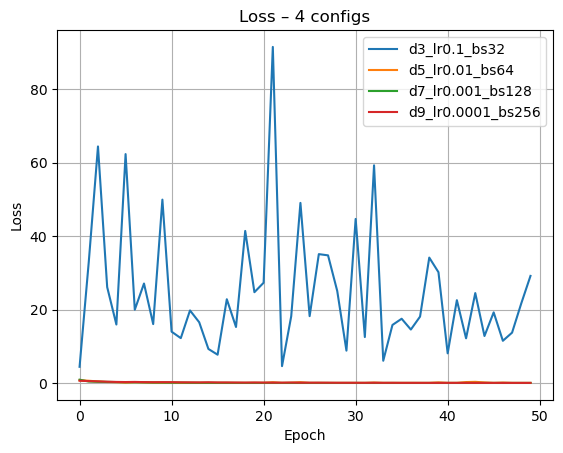

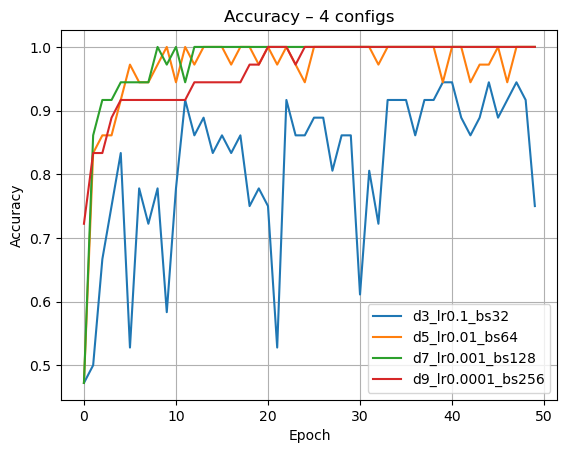

In [12]:
import matplotlib.pyplot as plt
# 1+2 plots
plt.figure(); 
plt.title("Loss – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['loss'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); 
plt.grid(); 
plt.show()

plt.figure(); 
plt.title("Accuracy – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['accuracy'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.grid(); 
plt.show()

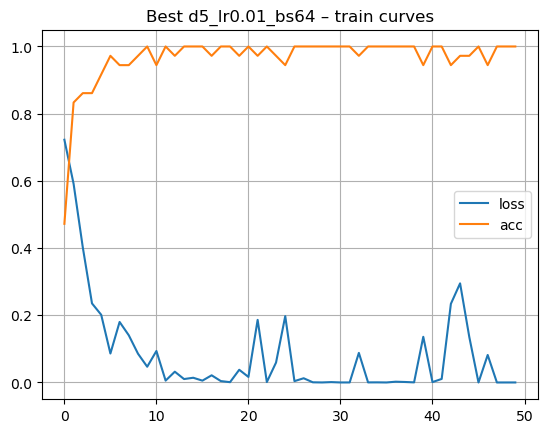

In [13]:
# 3 detailed curve for best
h=histories[best_key]
plt.figure(); 
plt.plot(h.history['loss'],label='loss'); 
plt.plot(h.history['accuracy'],label='acc')
plt.title(f"Best {best_key} – train curves"); 
plt.legend(); 
plt.grid(); 
plt.show()

In [14]:
slice_X, slice_y = [[] for _ in range(5)], [[] for _ in range(5)]

for subj, info in subject_dict.items():
    lbl  = info["label"]
    for i in range(5):
        slice_X[i].append(info["segments"][i+1])
        slice_y[i].append(lbl)

In [15]:
slice_X = [np.vstack(s) for s in slice_X]
slice_y = [np.array(s) for s in slice_y]

In [16]:
slice_X

[array([[7.72153946e-01, 3.30537658e-01, 5.46875000e-02, 9.88357050e-02,
         6.03626943e-02, 4.65025907e-02, 2.38155986e-01, 3.08430705e-02,
         4.66000000e-01, 3.59000000e-01, 5.00000000e-01, 2.75781250e+00],
        [6.95730864e-01, 5.31917628e-01, 2.57812500e-01, 8.90535506e-02,
         9.14918415e-02, 8.69463869e-02, 4.03997815e-01, 5.80681174e-02,
         7.85000000e-01, 7.46000000e-01, 1.17187500e-01, 3.94531250e+00],
        [6.07037589e-01, 3.29274278e-01, 1.87500000e-01, 7.77008114e-02,
         8.05076142e-02, 7.68527919e-02, 2.61394245e-01, 4.30606358e-02,
         7.93000000e-01, 7.57000000e-01, 2.26562500e-01, 1.87500000e+00],
        [7.97030834e-01, 3.10365730e-01, 5.46875000e-02, 1.02019947e-01,
         7.16378162e-02, 6.88415446e-02, 2.53329272e-01, 3.17841244e-02,
         5.38000000e-01, 5.17000000e-01, 1.48437500e-01, 2.18750000e+00],
        [3.83062260e-01, 2.80152027e-01, 1.25000000e-01, 4.90319693e-02,
         9.25783749e-02, 8.98912348e-02, 1.9385

In [17]:
slice_X = [scaler.transform(s) for s in slice_X]

In [18]:
slice_X

[array([[-1.65131941e-02, -3.28722316e-01, -1.12210563e+00,
         -1.65131941e-02, -2.49911239e+00, -2.92413486e+00,
         -3.12202515e-01, -7.87004641e-01, -1.09895665e+00,
         -1.30297383e+00,  3.33132835e+00, -3.13969313e-01],
        [-1.43690285e-01, -2.47884502e-01,  3.18622587e-01,
         -1.43690285e-01,  1.54209813e-01,  1.41229703e-01,
         -2.23047929e-01, -2.56518079e-01, -1.68247345e-01,
         -1.61345543e-01, -1.29945432e+00, -2.53557903e-01],
        [-2.91286439e-01, -3.29229461e-01, -1.80091028e-01,
         -2.91286439e-01, -7.82041154e-01, -6.23796123e-01,
         -2.99709905e-01, -5.48942455e-01, -1.44906673e-01,
         -1.28896160e-01,  2.36264422e-02, -3.58880427e-01],
        [ 2.48849058e-02, -3.36819718e-01, -1.12210563e+00,
          2.48849058e-02, -1.53806675e+00, -1.23099416e+00,
         -3.04045538e-01, -7.68667981e-01, -8.88890597e-01,
         -8.36882698e-01, -9.21431245e-01, -3.42982687e-01],
        [-6.64008008e-01, -3.4894808

In [19]:

# 4 confusion per slice
global_cm=np.zeros((2,2),int)
for i,(X_s,y_s) in enumerate(zip(slice_X,slice_y),start=2):
    y_pr=(best_model.predict(X_s).ravel()>=0.5).astype(int)
    cm=confusion_matrix(y_s,y_pr); global_cm+=cm
    tn,fp,fn,tp=cm.ravel()
    acc=(tp+tn)/cm.sum(); sens=tp/(tp+fn); spec=tn/(tn+fp); prec=tp/(tp+fp)
    print(f"Slice {i}‑th 5‑min  CM={cm.tolist()}  Acc={acc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  Prec={prec:.3f}")
    print(f"\\nGLOBAL CM =\\n", global_cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Slice 2‑th 5‑min  CM=[[0, 18], [3, 15]]  Acc=0.417  Sens=0.833  Spec=0.000  Prec=0.455
\nGLOBAL CM =\n [[ 0 18]
 [ 3 15]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Slice 3‑th 5‑min  CM=[[0, 18], [4, 14]]  Acc=0.389  Sens=0.778  Spec=0.000  Prec=0.438
\nGLOBAL CM =\n [[ 0 36]
 [ 7 29]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Slice 4‑th 5‑min  CM=[[0, 18], [3, 15]]  Acc=0.417  Sens=0.833  Spec=0.000  Prec=0.455
\nGLOBAL CM =\n [[ 0 54]
 [10 44]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Slice 5‑th 5‑min  CM=[[1, 17], [2, 16]]  Acc=0.472  Sens=0.889  Spec=0.056  Prec=0.485
\nGLOBAL CM =\n [[ 1 71]
 [12 60]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Slice 6‑th 5‑min  CM=[[2, 16], [1, 17]]  Acc=0.528  Sens=0.944  Spec=0.111  Prec=0.515
\nGLOBAL CM =\n [[ 3 87]
 [13 77]]


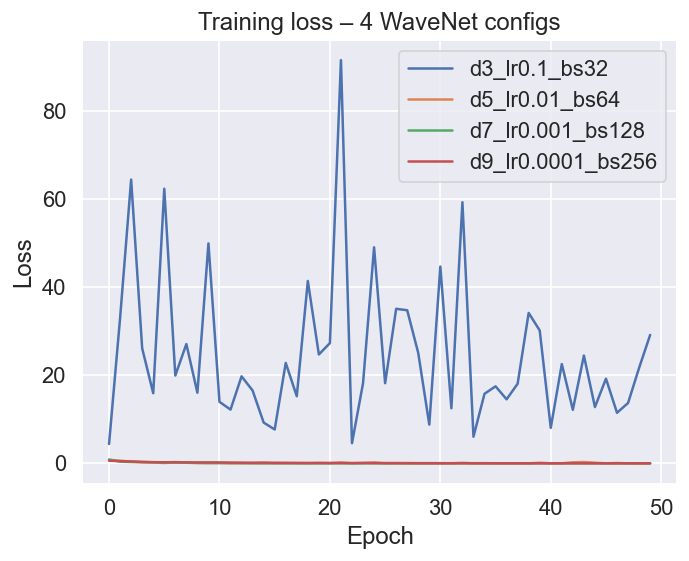

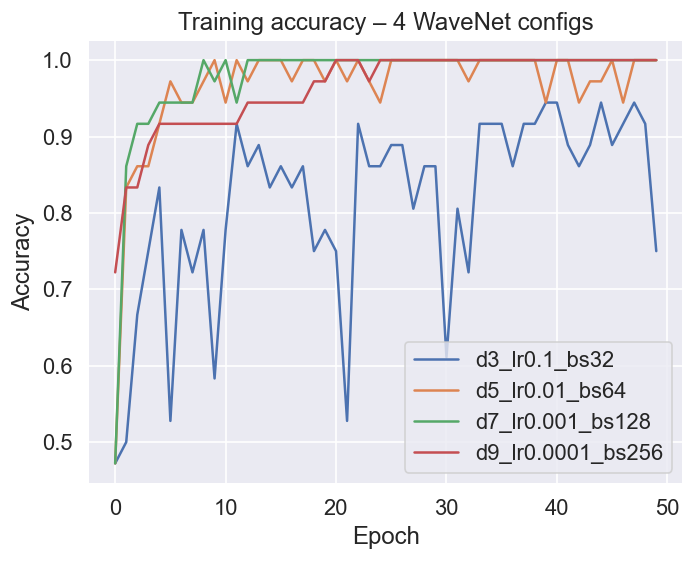

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, rc={"figure.dpi":120})

# ──────────────────────────────────────────
# ① Loss curves of the four configs
plt.figure()
for k,h in histories.items():
    plt.plot(h.history['loss'], label=k)
plt.title("Training loss – 4 WaveNet configs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
plt.show()

# ② Accuracy curves of the four configs
plt.figure()
for k,h in histories.items():
    plt.plot(h.history['accuracy'], label=k)
plt.title("Training accuracy – 4 WaveNet configs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()
plt.show()

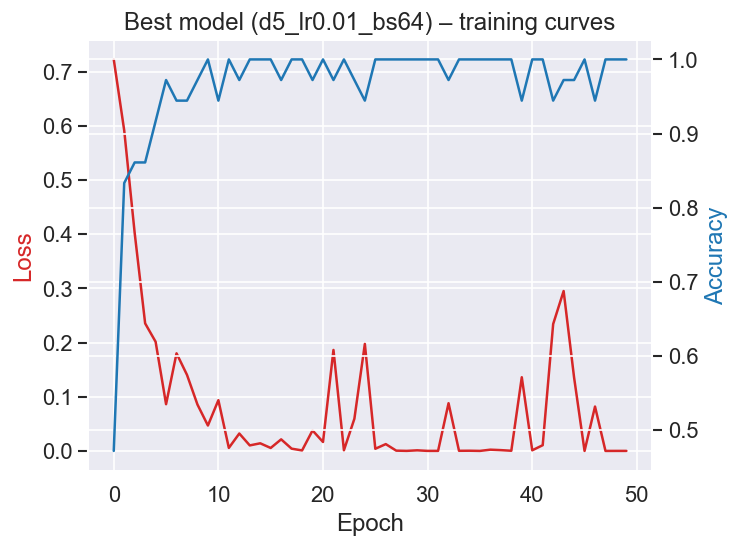

In [21]:
# ③ Detailed loss + acc for the best model
best_hist = histories[best_key]
fig, ax1 = plt.subplots()
ax1.plot(best_hist.history['loss'], label="loss", color="tab:red")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss", color="tab:red")
ax2 = ax1.twinx()
ax2.plot(best_hist.history['accuracy'], label="acc", color="tab:blue")
ax2.set_ylabel("Accuracy", color="tab:blue")
plt.title(f"Best model ({best_key}) – training curves")
fig.tight_layout(); plt.grid(True); plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


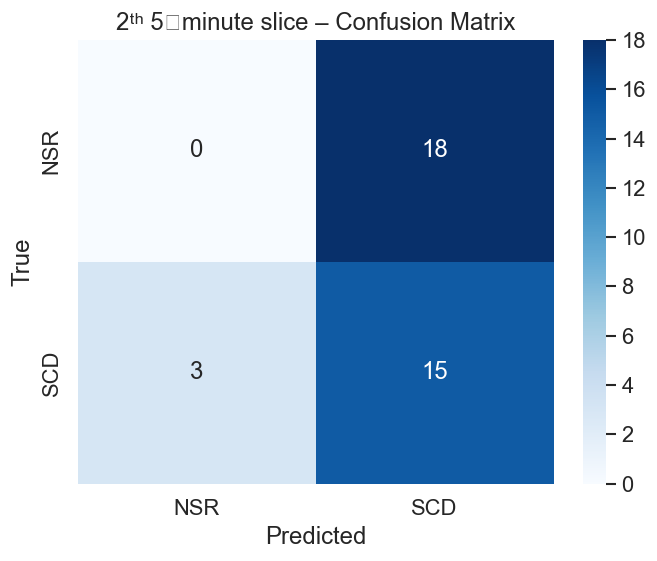

Slice 2:  Acc=0.417  Sens=0.833  Spec=0.000  Prec=0.455
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


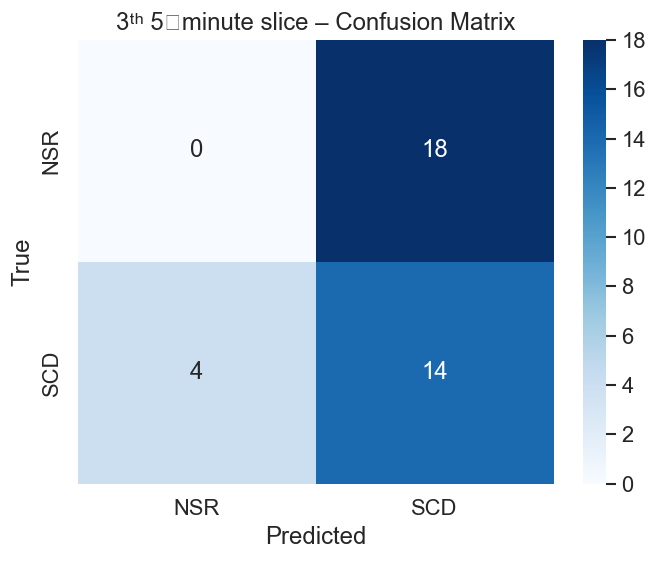

Slice 3:  Acc=0.389  Sens=0.778  Spec=0.000  Prec=0.438
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


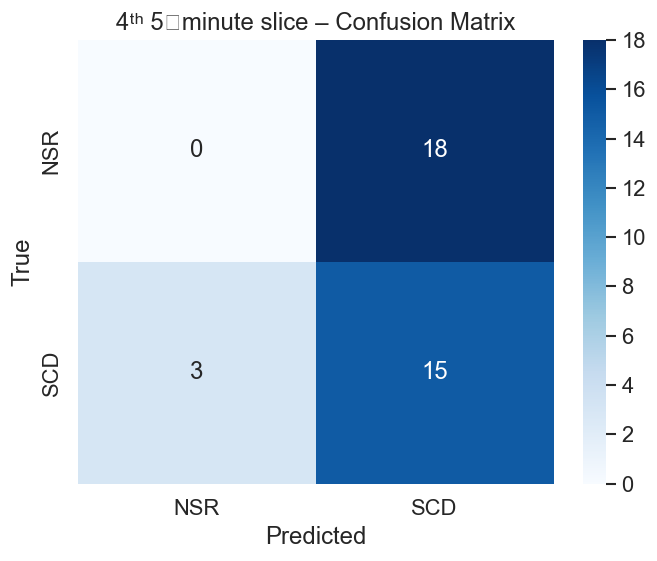

Slice 4:  Acc=0.417  Sens=0.833  Spec=0.000  Prec=0.455
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


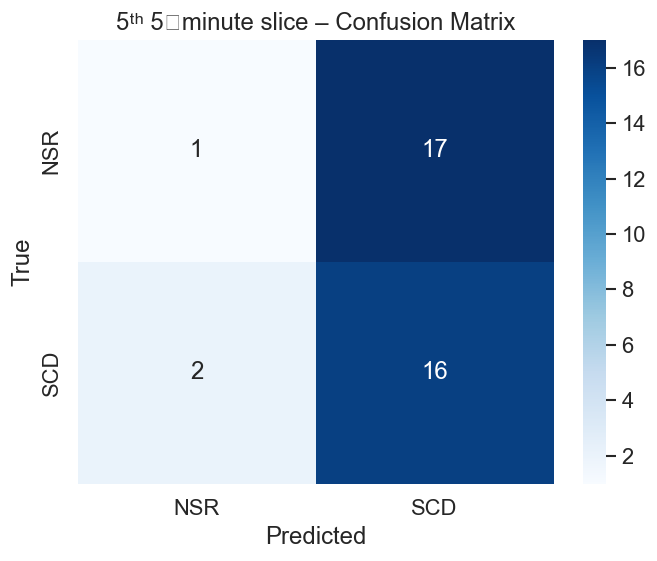

Slice 5:  Acc=0.472  Sens=0.889  Spec=0.056  Prec=0.485
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


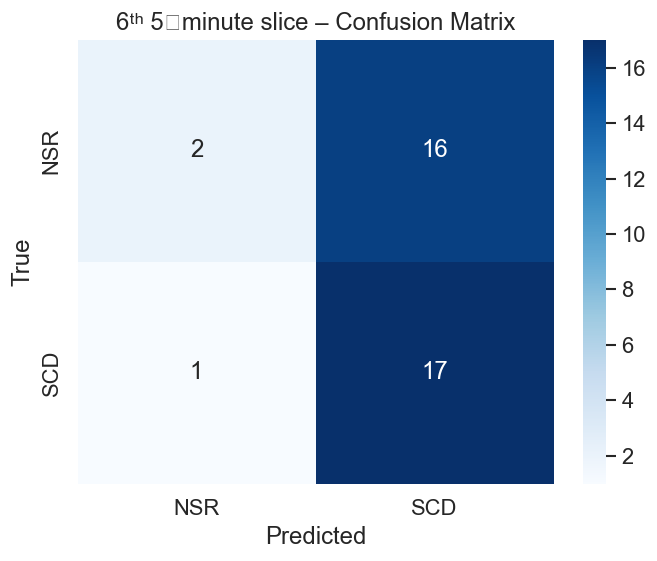

Slice 6:  Acc=0.528  Sens=0.944  Spec=0.111  Prec=0.515


In [22]:
# ──────────────────────────────────────────
# ④ Slice‑wise confusion matrices (heat‑maps)
labels = ["NSR", "SCD"]
global_cm = np.zeros((2,2), int)

for idx, (X_s, y_s) in enumerate(zip(slice_X, slice_y), start=2):
    y_pred = (best_model.predict(X_s).ravel() >= 0.5).astype(int)
    cm = confusion_matrix(y_s, y_pred)
    global_cm += cm

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"{idx}ᵗʰ 5‑minute slice – Confusion Matrix")
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    acc  = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp+fn) else 0
    spec = tn / (tn + fp) if (tn+fp) else 0
    prec = tp / (tp + fp) if (tp+fp) else 0
    print(f"Slice {idx}:  Acc={acc:.3f}  Sens={sens:.3f}  "
          f"Spec={spec:.3f}  Prec={prec:.3f}")